In [110]:
import os

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [112]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(1)/filtered_data_low_level.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,HP PAVILION X360 15-8130U-8GB-256GB-TOUCH-WIN1...,6465000,2013-01-14,12
1,HP Pavilion 13 AN0031 i3 8145U 8GB 128GB-SSD I...,7799000,2013-01-17,16
2,HP Pavilion ENVY 13 AN0031WM - i3 8145U 8GB 12...,7799000,2013-02-26,9
3,HP 14s dk1122AU dk1123AU - AMD Athlon Gold 315...,6899000,2013-03-14,10
4,Dell Latitude E5440 |Core i5-Gen 4 |Camera - R...,3300000,2013-04-06,23
5,Dell Latitude E7440 |Core i5-Gen 4 |Camera - R...,3750000,2013-04-07,17
6,Dell Latitude E7450 |Core i7-Gen 5 |Camera - R...,5199000,2013-04-08,19
7,Dell inspiron 3180-A99420-4-500-U-WIN10H-GREY ...,3900000,2013-04-09,13
8,Dell inspiron 3443,4800000,2013-04-10,19
9,"Dell inspiron Amd A9 memori 4gb,hardis 500gb K...",3750000,2013-04-11,16


In [113]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    972 non-null    object
 1   price   972 non-null    int64 
 2   date    972 non-null    object
 3   sales   972 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ KB


In [114]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [115]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    972 non-null    object
 1   sales   972 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ KB


In [116]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [117]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    972 non-null    datetime64[ns]
 1   sales   972 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 KB


In [118]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [119]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [120]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,99
1,2013-02-01,162
2,2013-03-01,290
3,2013-04-01,500
4,2013-05-01,558
5,2013-06-01,570
6,2013-07-01,663
7,2013-08-01,283
8,2013-09-01,368
9,2013-10-01,253


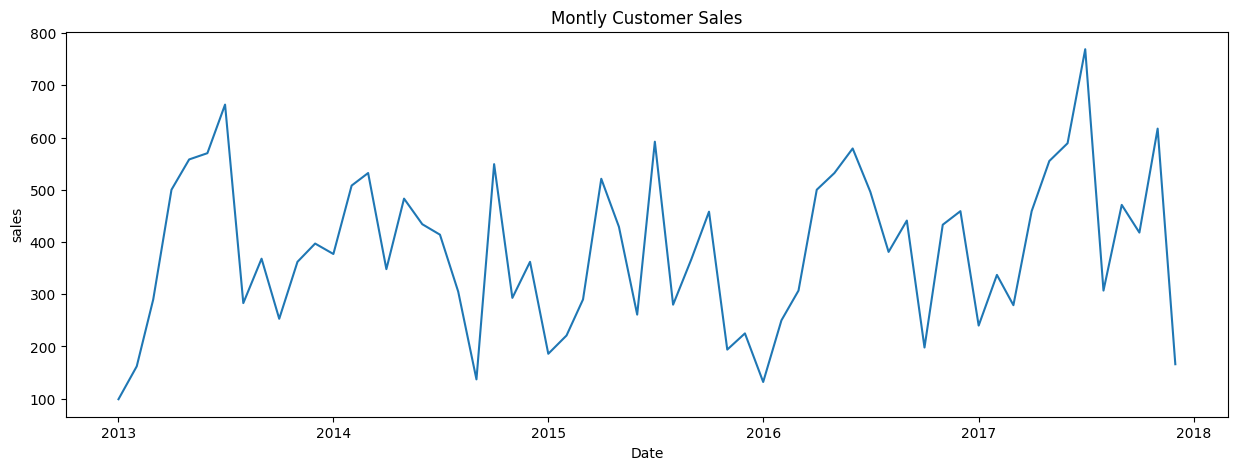

In [121]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [122]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,162,63.0
2,2013-03-01,290,128.0
3,2013-04-01,500,210.0
4,2013-05-01,558,58.0
5,2013-06-01,570,12.0
6,2013-07-01,663,93.0
7,2013-08-01,283,-380.0
8,2013-09-01,368,85.0
9,2013-10-01,253,-115.0
10,2013-11-01,362,109.0


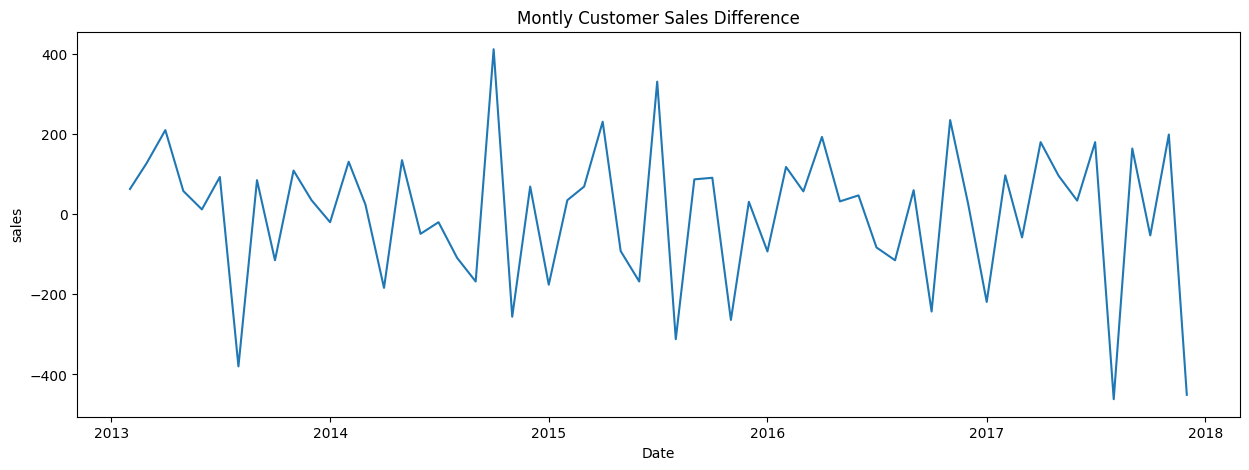

In [123]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [124]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [125]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0,12.0,58.0,210.0,128.0,63.0
1,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0,12.0,58.0,210.0,128.0
2,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0,12.0,58.0,210.0
3,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0,12.0,58.0
4,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0,12.0
5,-20.0,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0,93.0
6,-109.0,-20.0,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0,-380.0
7,-168.0,-109.0,-20.0,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0,85.0
8,412.0,-168.0,-109.0,-20.0,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0,-115.0
9,-256.0,412.0,-168.0,-109.0,-20.0,-49.0,135.0,-184.0,24.0,131.0,-20.0,35.0,109.0


In [126]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [127]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [128]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [129]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [130]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[459, 240, 337, 279, 459, 555, 589, 769, 307, 471, 418, 617, 166]


In [131]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [132]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [133]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [134]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  182.20951324414742
Linaer Regression MAE :  154.04703367855166
Linaer Regression R2 :  -9.281705312295557


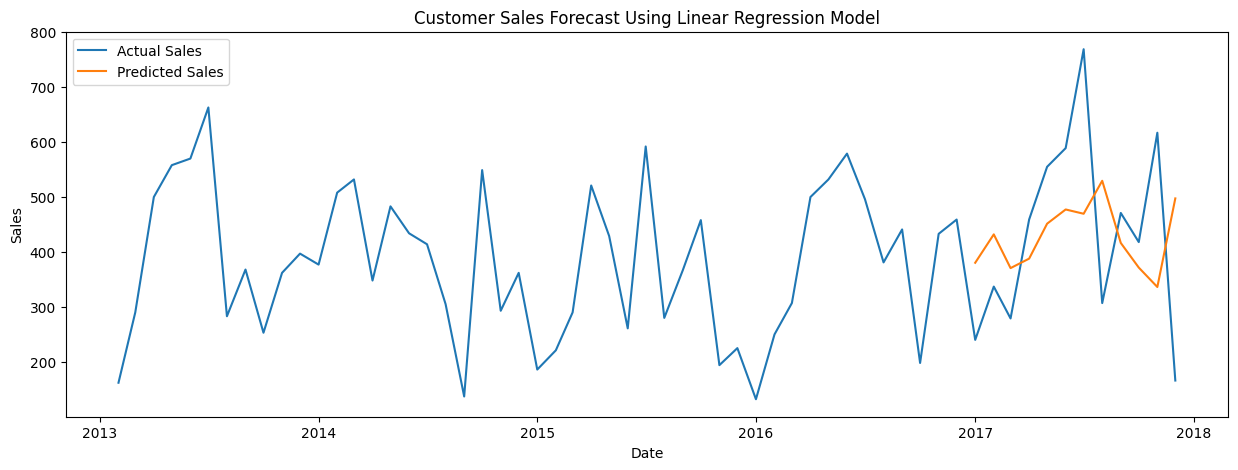

In [135]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()